## NB:
Terima kasih kepada Apri di Braincore.id yang telah membantu saya menyelesaikan projek KRL Infographics ini dengan cara memberi insights yang tidak terpikirkan oleh saya dalam menganalisis terhadap dataset yang telah ada.

## Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

## Read the Dataset

In [2]:
schedule = pd.read_csv('dataset/schedule.csv')
station = pd.read_csv('dataset/station.csv')

## Preprocessing & Feature Engineering

In [3]:
schedule['destination_time'] = schedule['destination_time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
schedule['time_estimated'] = schedule['time_estimated'].apply(lambda x: datetime.strptime(x, '%H:%M:%S'))

In [4]:
df = pd.merge(schedule, station, left_on="station_id", right_on="id", how="inner")
df.drop(['id_y','updated_at_x','updated_at_y', 'daop', 'fg_enable','have_schedule'], axis=1, inplace=True)
df['origin'] = df['route'].apply(lambda x: x.split("-")[0])
df = df.rename(columns={"name": "station_name"})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18065 entries, 0 to 18064
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_x              18065 non-null  object        
 1   station_id        18065 non-null  object        
 2   train_id          18065 non-null  object        
 3   line              18065 non-null  object        
 4   route             18065 non-null  object        
 5   color             18065 non-null  object        
 6   destination       18065 non-null  object        
 7   time_estimated    18065 non-null  datetime64[ns]
 8   destination_time  18065 non-null  datetime64[ns]
 9   station_name      18065 non-null  object        
 10  origin            18065 non-null  object        
dtypes: datetime64[ns](2), object(9)
memory usage: 1.5+ MB


In [6]:
df.head()

,id_x,station_id,train_id,line,route,color,destination,time_estimated,destination_time,station_name,origin
0,AC-2400,AC,2400,COMMUTER LINE TANJUNGPRIUK,JAKARTAKOTA-TANJUNGPRIUK,#DD0067,TANJUNGPRIUK,1900-01-01 06:07:00,1900-01-01 06:16:00,ANCOL,JAKARTAKOTA
1,AC-2401,AC,2401,COMMUTER LINE TANJUNGPRIUK,TANJUNGPRIUK-JAKARTAKOTA,#DD0067,JAKARTAKOTA,1900-01-01 06:34:00,1900-01-01 06:42:00,ANCOL,TANJUNGPRIUK
2,AC-2402,AC,2402,COMMUTER LINE TANJUNGPRIUK,JAKARTAKOTA-TANJUNGPRIUK,#DD0067,TANJUNGPRIUK,1900-01-01 06:24:00,1900-01-01 06:33:00,ANCOL,JAKARTAKOTA
3,AC-2403,AC,2403,COMMUTER LINE TANJUNGPRIUK,TANJUNGPRIUK-JAKARTAKOTA,#DD0067,JAKARTAKOTA,1900-01-01 06:50:00,1900-01-01 06:58:00,ANCOL,TANJUNGPRIUK
4,AC-2404,AC,2404,COMMUTER LINE TANJUNGPRIUK,JAKARTAKOTA-TANJUNGPRIUK,#DD0067,TANJUNGPRIUK,1900-01-01 06:43:00,1900-01-01 06:52:00,ANCOL,JAKARTAKOTA


In [7]:
# add hourly schedule
df['time_estimated_hour'] = df['time_estimated'].dt.hour

In [8]:
def calculate_feat_ab(row):
    departure = row['time_estimated']
    arrival = row['destination_time']

    if departure > arrival:
        arrival += timedelta(hours=24)

    time_difference = arrival - departure
    return time_difference.total_seconds() / 60

# add estimated trip time
df['estimated_trip_time'] = df.apply(calculate_feat_ab, axis=1)

In [9]:
# create train table
train1 = df.copy()
train2 = df.copy()

train1 = train1.groupby(['line','route','train_id'])['station_name'].nunique().reset_index(name='no_station')
train2 = train2.groupby(['line','route','train_id'])['estimated_trip_time'].max().reset_index()

train = pd.merge(train1, train2, on="train_id", how="inner")
train = train.drop(['line_y','route_y'], axis=1)
train = train.rename(columns={"line_x": "line", "route_x": "route"})
train

,line,route,train_id,no_station,estimated_trip_time
0,COMMUTER LINE BOGOR,BOGOR-DEPOK,1063C,4,28.0
1,COMMUTER LINE BOGOR,BOGOR-DEPOK,1065C,4,28.0
2,COMMUTER LINE BOGOR,BOGOR-DEPOK,1067C,4,28.0
3,COMMUTER LINE BOGOR,BOGOR-DEPOK,1069C,4,28.0
4,COMMUTER LINE BOGOR,BOGOR-DEPOK,1381C,4,28.0
...,...,...,...,...,...
1279,PRAMBANAN EKSPRES (PRAMEKS),KUTOARJO-YOGYAKARTA,556,4,67.0
1280,PRAMBANAN EKSPRES (PRAMEKS),KUTOARJO-YOGYAKARTA,558,4,70.0
1281,PRAMBANAN EKSPRES (PRAMEKS),YOGYAKARTA-KUTOARJO,551,4,67.0
1282,PRAMBANAN EKSPRES (PRAMEKS),YOGYAKARTA-KUTOARJO,553,4,81.0


## EDA

### 1. Rute dengan kereta paling banyak

In [10]:
df.groupby('route')['train_id'].nunique().sort_values(ascending=False)

route
JAKARTAKOTA-BOGOR           120
BOGOR-JAKARTAKOTA           116
TANGERANG-DURI               61
DURI-TANGERANG               61
TANAHABANG-RANGKASBITUNG     59
                           ... 
ANGKE-TAMBUN                  1
MANGGARAI-TANAH ABANG         1
JAKARTAKOTA-CIKARANG          1
CAKUNG-CIKARANG               1
MANGGARAI-DEPOK               1
Name: train_id, Length: 69, dtype: int64

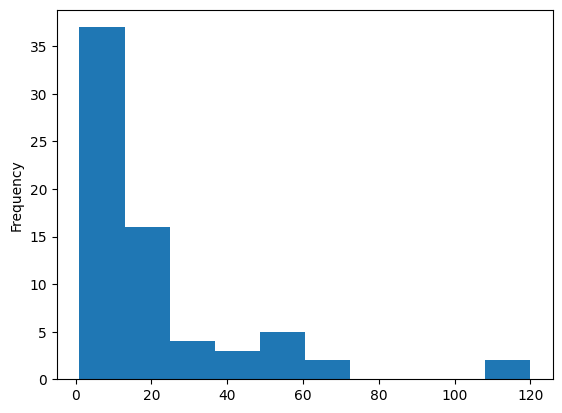

In [11]:
df.groupby('route')['train_id'].nunique().sort_values(ascending=False).plot(kind='hist')
plt.show()

### 2. Banyaknya kereta yang dilalui dari setiap stasiun

In [12]:
df.groupby('route')['station_name'].nunique().sort_values(ascending=False)

route
CIKARANG-KAMPUNGBANDAN      26
KAMPUNGBANDAN-CIKARANG      25
TAMBUN-KAMPUNGBANDAN        23
BOGOR-JAKARTAKOTA           23
JAKARTAKOTA-BOGOR           23
                            ..
JAKARTAKOTA-TANJUNGPRIUK     3
DEPOK-NAMBO                  3
TANJUNGPRIUK-JAKARTAKOTA     3
DEPOK-BOJONGGEDE             2
RANGKASBITUNG-MERAK          1
Name: station_name, Length: 69, dtype: int64

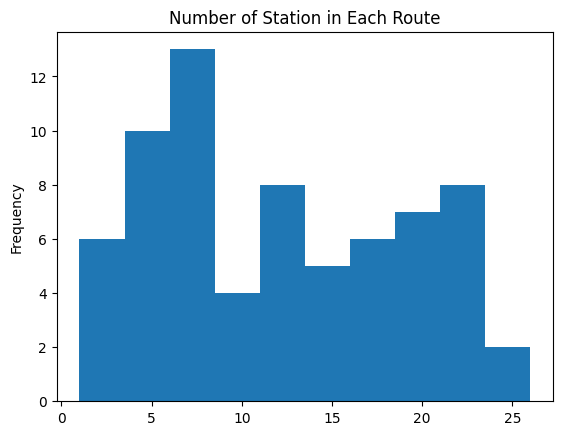

In [13]:
df.groupby('route')['station_name'].nunique().sort_values(ascending=False).plot(kind='hist')
plt.title('Number of Station in Each Route')
plt.show()

### 3. Stasiun dengan jadwal kereta tersibuk

In [14]:
df.groupby('station_name')['train_id'].nunique().sort_values(ascending=False)

station_name
MANGGARAI     532
TANAHABANG    363
DURI          357
CITAYAM       356
DEPOK         347
             ... 
NAMBO          12
WATES           8
WOJO            8
JENAR           8
KUTOARJO        4
Name: train_id, Length: 100, dtype: int64

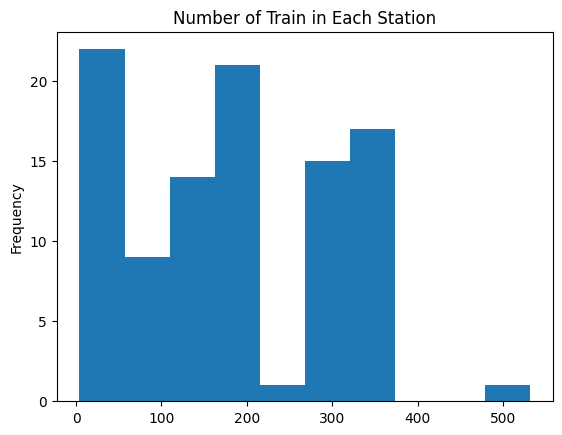

In [15]:
df.groupby('station_name')['train_id'].nunique().sort_values(ascending=False).plot(kind='hist')
plt.title('Number of Train in Each Station')
plt.show()

### 4. Stasiun yang paling sering dilewati suatu rute

In [16]:
df.groupby('station_name')['route'].nunique().sort_values(ascending=False)
#Stasiun manggarai setidaknya tergabung dalam 27 rute perjalanan kereta yang berbeda

station_name
MANGGARAI               27
TANAHABANG              22
KRANJI                  19
CAKUNG                  19
KARET                   19
                        ..
TANJUNGPRIUK             1
KUTOARJO                 1
NAMBO                    1
PALUR                    1
BANDARASOEKARNOHATTA     1
Name: route, Length: 100, dtype: int64

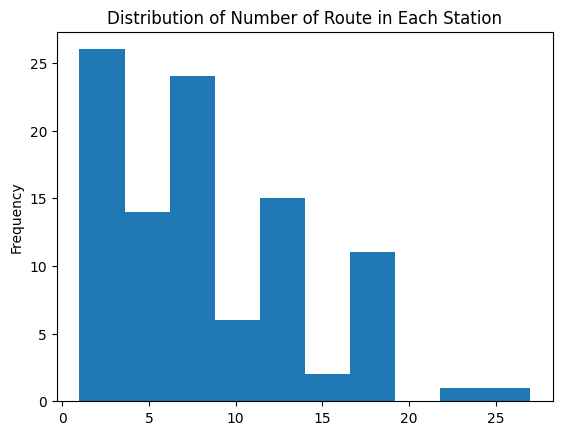

In [17]:
df.groupby('station_name')['route'].nunique().sort_values(ascending=False).plot(kind='hist')
plt.title('Distribution of Number of Route in Each Station')
plt.show()

In [18]:
# explore manggarai
df[df['station_name'] == 'MANGGARAI']['route'].value_counts()

route
JAKARTAKOTA-BOGOR          120
BOGOR-JAKARTAKOTA          116
KAMPUNGBANDAN-CIKARANG      32
KAMPUNGBANDAN-BEKASI        31
BEKASI-KAMPUNGBANDAN        27
CIKARANG-KAMPUNGBANDAN      26
MANGGARAI-BOGOR             25
CIKARANG-ANGKE              22
MANGGARAI-KAMPUNGBANDAN     19
ANGKE-CIKARANG              14
ANGKE-BEKASI                14
BEKASI-ANGKE                13
DEPOK-JAKARTAKOTA           13
JAKARTAKOTA-DEPOK           13
NAMBO-JAKARTAKOTA           12
JAKARTAKOTA-NAMBO           10
MANGGARAI-ANGKE              9
MANGGARAI-CIKARANG           4
MANGGARAI-BEKASI             3
BOJONGGEDE-JAKARTAKOTA       2
ANGKE-TAMBUN                 1
CILEBUT-JAKARTAKOTA          1
MANGGARAI-DEPOK              1
KAMPUNGBANDAN-TAMBUN         1
MANGGARAI-DURI               1
MANGGARAI-TANAH ABANG        1
TAMBUN-KAMPUNGBANDAN         1
Name: count, dtype: int64

### 5. Distribusi kereta yang melewati setiap line

In [19]:
df.groupby('station_name')['line'].nunique().sort_values(ascending=False)

station_name
TANAHABANG       4
MANGGARAI        4
KARET            4
SUDIRMAN         4
SUDIRMAN BARU    4
                ..
GANGSENTIONG     1
DURENKALIBATA    1
DEPOKBARU        1
DEPOK            1
KRANJI           1
Name: line, Length: 100, dtype: int64

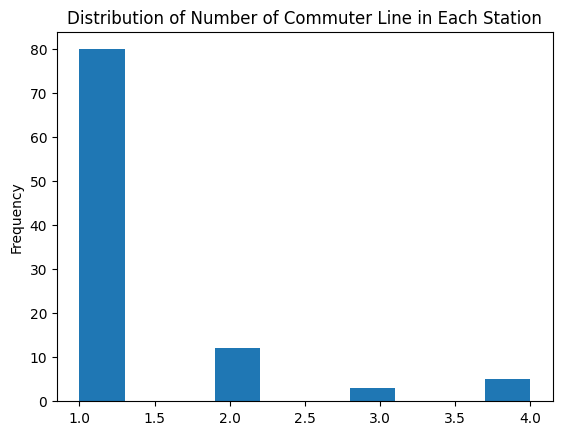

In [20]:
df.groupby('station_name')['line'].nunique().sort_values(ascending=False).plot(kind='hist')
plt.title('Distribution of Number of Commuter Line in Each Station')
plt.show()

### 6. Stasiun berdasarkan daerah operasional

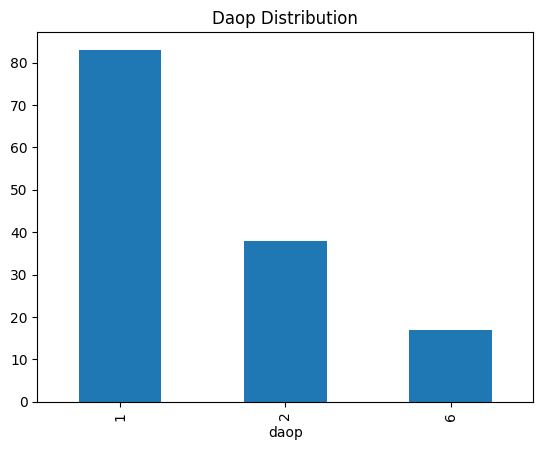

In [21]:
station['daop'].value_counts().plot(kind='bar')
plt.title('Daop Distribution')
plt.show()

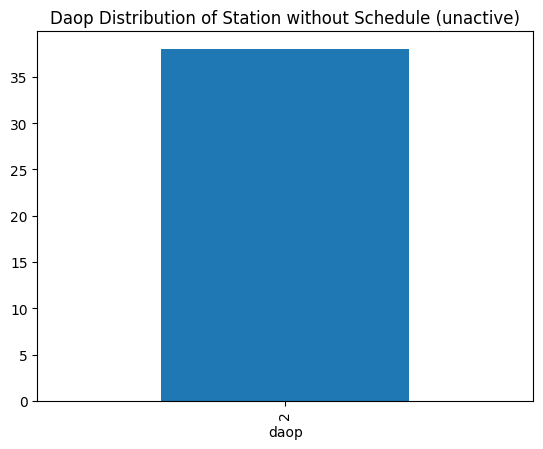

In [22]:
station[station['have_schedule'] == False]['daop'].value_counts().plot(kind='bar')
plt.title('Daop Distribution of Station without Schedule (unactive)')
plt.show()

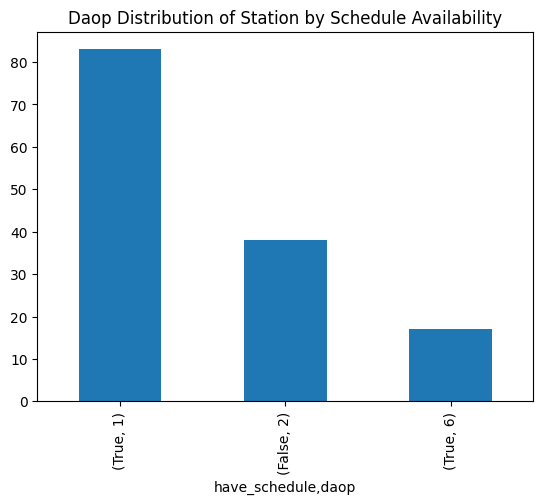

In [23]:
station[['have_schedule','daop']].value_counts().plot(kind='bar')
plt.title('Daop Distribution of Station by Schedule Availability')
plt.show()

### 7. Stasiun yang masih beroperasi/memiliki jadwal

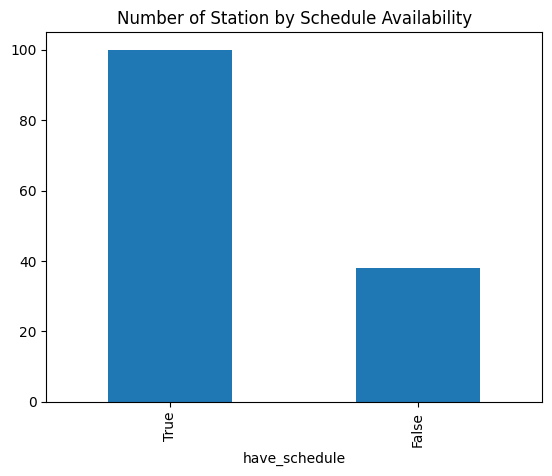

In [24]:
station['have_schedule'].value_counts().plot(kind='bar')
plt.title('Number of Station by Schedule Availability')
plt.show()

In [25]:
station[station['have_schedule'] == False]

,id,name,daop,fg_enable,have_schedule,updated_at
3,BD,BANDUNG,2,1,False,2024-03-10T15:15:19.997Z
12,CA,CIGANEA,2,1,False,2024-03-10T15:15:19.997Z
13,CB,CIBATU,2,1,False,2024-03-10T15:15:19.997Z
15,CBR,CIBUNGUR,2,1,False,2024-03-10T15:15:19.997Z
17,CCL,CICALENGKA,2,1,False,2024-03-10T15:15:19.997Z
18,CD,CIKADONGDONG,2,1,False,2024-03-10T15:15:19.997Z
23,CKP,CIKAMPEK,2,1,False,2024-03-10T15:15:19.997Z
26,CLE,CILAME,2,1,False,2024-03-10T15:15:19.997Z
28,CMD,CIMINDI,2,1,False,2024-03-10T15:15:19.997Z
29,CMI,CIMAHI,2,1,False,2024-03-10T15:15:19.997Z


### 8. Distribusi keberangkatan kereta tiap jam

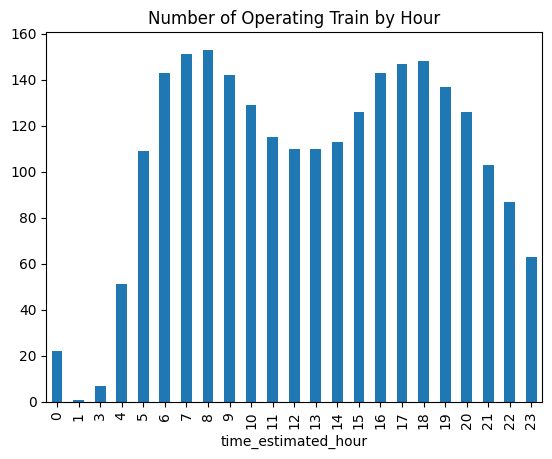

In [26]:
# per kereta
df.groupby('time_estimated_hour')['train_id'].nunique().plot(kind='bar')
plt.title('Number of Operating Train by Hour')
plt.show()

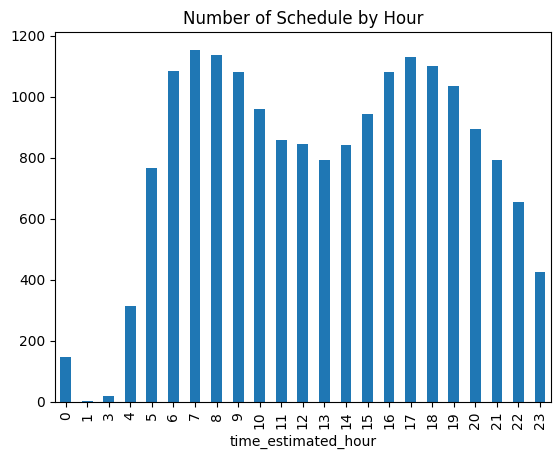

In [27]:
# per jadwal
df.groupby('time_estimated_hour')['id_x'].nunique().plot(kind='bar')
plt.title('Number of Schedule by Hour')
plt.show()

### 9. Korelasi Kesibukan stasiun dengan daftar operasional

In [28]:
temp = df.copy()
temp = temp.groupby('station_name')['id_x'].nunique().reset_index(name='no_schedule')
temp1 = pd.merge(temp, station, left_on="station_name", right_on="name", how="inner")
temp1.drop(['id','name','updated_at'], axis=1, inplace=True)
temp1.head()

,station_name,no_schedule,daop,fg_enable,have_schedule
0,ANCOL,86,1,1,True
1,ANGKE,195,1,1,True
2,BANDARASOEKARNOHATTA,28,1,1,True
3,BATUCEPER,178,1,1,True
4,BEKASI,228,1,1,True


In [29]:
temp1.corr(numeric_only=True)

,no_schedule,daop,fg_enable,have_schedule
no_schedule,1.000000,-0.607807,NaN,NaN
daop,-0.607807,1.000000,NaN,NaN
fg_enable,NaN,NaN,NaN,NaN
have_schedule,NaN,NaN,NaN,NaN


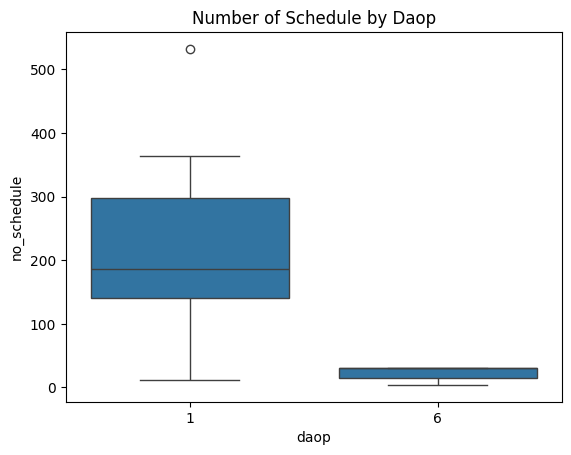

In [30]:
sns.boxplot(x='daop', y='no_schedule', data=temp1)
plt.title('Number of Schedule by Daop')
plt.show()

In [31]:
temp1.groupby('daop')['no_schedule'].describe()

,count,mean,std,min,25%,50%,75%,max
daop,,,,,,,,
1,83.0,212.927711,102.800990,12.0,141.0,186.0,297.0,532.0
6,17.0,23.058824,10.170242,4.0,15.0,30.0,30.0,30.0


### 10. Line terpendek dan terpanjang

In [32]:
train.groupby('line')['no_station'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
line,,,,,,,,
COMMUTER LINE BOGOR,384.0,19.416667,6.258849,2.0,16.0,23.0,23.0,23.0
COMMUTER LINE CIKARANG,357.0,14.574230,4.528711,5.0,13.0,15.0,19.0,20.0
COMMUTER LINE RANGKASBITUNG,204.0,14.367647,4.501465,3.0,10.0,18.0,18.0,18.0
COMMUTER LINE YK,30.0,12.000000,0.000000,12.0,12.0,12.0,12.0,12.0
COMMUTER LINE TANGERANG,124.0,9.919355,0.632414,5.0,10.0,10.0,10.0,10.0
COMMUTER LINE BST,84.0,7.000000,1.422707,5.0,5.0,8.0,8.0,8.0
PRAMBANAN EKSPRES,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
PRAMBANAN EKSPRES (PRAMEKS),7.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
COMMUTER LINE TANJUNGPRIUK,86.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


### 11. Kereta dengan durasi total perjalanan terlama

In [33]:
train

,line,route,train_id,no_station,estimated_trip_time
0,COMMUTER LINE BOGOR,BOGOR-DEPOK,1063C,4,28.0
1,COMMUTER LINE BOGOR,BOGOR-DEPOK,1065C,4,28.0
2,COMMUTER LINE BOGOR,BOGOR-DEPOK,1067C,4,28.0
3,COMMUTER LINE BOGOR,BOGOR-DEPOK,1069C,4,28.0
4,COMMUTER LINE BOGOR,BOGOR-DEPOK,1381C,4,28.0
...,...,...,...,...,...
1279,PRAMBANAN EKSPRES (PRAMEKS),KUTOARJO-YOGYAKARTA,556,4,67.0
1280,PRAMBANAN EKSPRES (PRAMEKS),KUTOARJO-YOGYAKARTA,558,4,70.0
1281,PRAMBANAN EKSPRES (PRAMEKS),YOGYAKARTA-KUTOARJO,551,4,67.0
1282,PRAMBANAN EKSPRES (PRAMEKS),YOGYAKARTA-KUTOARJO,553,4,81.0


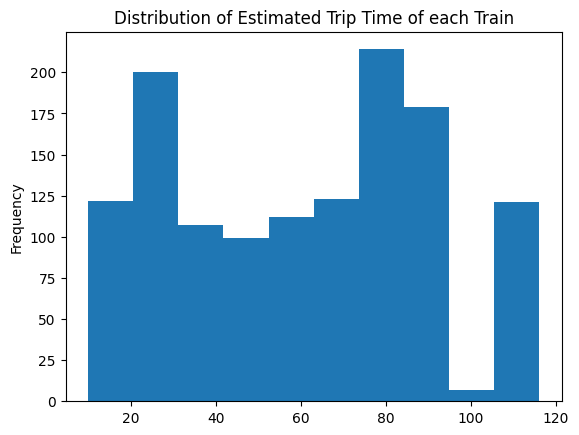

In [34]:
train['estimated_trip_time'].plot(kind='hist')
plt.title('Distribution of Estimated Trip Time of each Train')
plt.show()

### 12. Korelasi panjang rute terhadap waktu tempuh

In [35]:
train.select_dtypes("number").corr()

,no_station,estimated_trip_time
no_station,1.000000,0.824142
estimated_trip_time,0.824142,1.000000


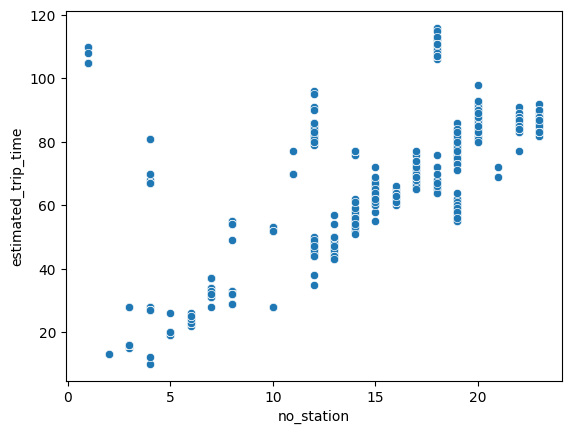

In [36]:
sns.scatterplot(x='no_station', y='estimated_trip_time', data=train)
plt.show()

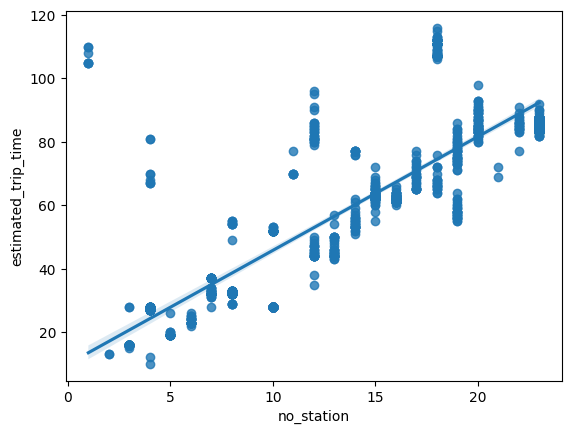

In [37]:
sns.regplot(x='no_station', y='estimated_trip_time', data=train)
plt.show()

### 13. Distribusi panjang rute

In [38]:
train.groupby('route')['no_station'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
route,,,,,,,,
JAKARTAKOTA-BOGOR,120.0,23.0,0.0,23.0,23.0,23.0,23.0,23.0
BOGOR-JAKARTAKOTA,116.0,23.0,0.0,23.0,23.0,23.0,23.0,23.0
JAKARTAKOTA-NAMBO,10.0,22.0,0.0,22.0,22.0,22.0,22.0,22.0
CILEBUT-JAKARTAKOTA,1.0,22.0,NaN,22.0,22.0,22.0,22.0,22.0
NAMBO-JAKARTAKOTA,12.0,22.0,0.0,22.0,22.0,22.0,22.0,22.0
...,...,...,...,...,...,...,...,...
JAKARTAKOTA-TANJUNGPRIUK,43.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
SERPONG-PARUNGPANJANG,1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
DEPOK-NAMBO,2.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0


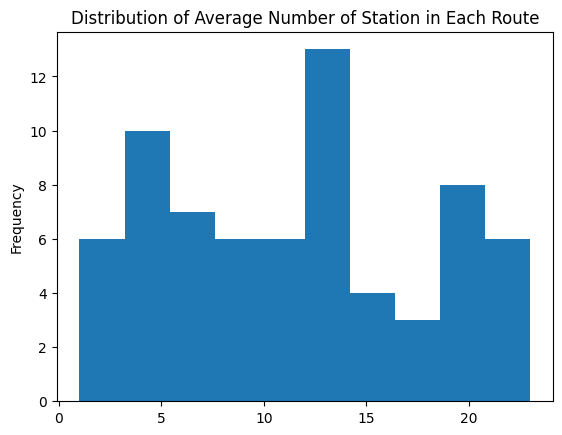

In [39]:
train.groupby('route')['no_station'].mean().plot(kind='hist')
plt.title('Distribution of Average Number of Station in Each Route') # Distribusi rata rata angka stasiun per rute = jadi per rute itu ada berapa stasiun gitu
plt.show()

### 14. Rata-rata waktu tempuh perline-perroute

In [40]:
train.groupby('line')['estimated_trip_time'].mean().sort_values(ascending=False)

line
COMMUTERLINE MERAK             106.857143
COMMUTER LINE RANGKASBITUNG     84.691176
COMMUTER LINE YK                83.933333
COMMUTER LINE BOGOR             72.940104
PRAMBANAN EKSPRES (PRAMEKS)     71.857143
PRAMBANAN EKSPRES               68.000000
COMMUTER LINE CIKARANG          59.392157
COMMUTER LINE BST               28.000000
COMMUTER LINE TANGERANG         27.870968
COMMUTER LINE TANJUNGPRIUK      16.000000
Name: estimated_trip_time, dtype: float64

In [41]:
df[df['train_id'] == '662'].sort_values(by='time_estimated')

,id_x,station_id,train_id,line,route,color,destination,time_estimated,destination_time,station_name,origin,time_estimated_hour,estimated_trip_time
18050,YK-662,YK,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 06:50:00,1900-01-01 08:15:00,YOGYAKARTA,YOGYAKARTA,6,85.0
10180,LPN-662,LPN,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 06:55:00,1900-01-01 08:15:00,LEMPUYANGAN,YOGYAKARTA,6,80.0
10497,MGW-662,MGW,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:02:00,1900-01-01 08:15:00,MAGUWO,YOGYAKARTA,7,73.0
282,BBN-662,BBN,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:10:00,1900-01-01 08:15:00,BRAMBANAN,YOGYAKARTA,7,65.0
15293,SWT-662,SWT,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:17:00,1900-01-01 08:15:00,SROWOT,YOGYAKARTA,7,58.0
9808,KT-662,KT,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:24:00,1900-01-01 08:15:00,KLATEN,YOGYAKARTA,7,51.0
2071,CE-662,CE,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:33:00,1900-01-01 08:15:00,CEPER,YOGYAKARTA,7,42.0
4662,DL-662,DL,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:40:00,1900-01-01 08:15:00,DELANGGU,YOGYAKARTA,7,35.0
6582,GW-662,GW,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:46:00,1900-01-01 08:15:00,GAWOK,YOGYAKARTA,7,29.0
13469,PWS-662,PWS,662,COMMUTER LINE YK,YOGYAKARTA-PALUR,#E30A16,PALUR,1900-01-01 07:53:00,1900-01-01 08:15:00,PURWOSARI,YOGYAKARTA,7,22.0


## Informasi Tambahan

In [42]:
# total kereta yang tersedia
print("Kereta yang tersedia:", df["train_id"].nunique(), "unit")

Kereta yang tersedia: 1284 unit


In [43]:
# apakah ada kereta yang melewati lebih dari satu line (jawabannya tidak ada)
df.groupby("train_id")["line"].nunique().sort_values(ascending=False)

train_id
1000B       1
312         1
4070        1
4069        1
4068A       1
           ..
1652        1
1651        1
1650        1
1649        1
D1/5714A    1
Name: line, Length: 1284, dtype: int64

In [44]:
# apakah ada kereta yang mempunya lebih dari satu rute
df.groupby("train_id")["route"].nunique().sort_values(ascending=False)

train_id
1000B       1
312         1
4070        1
4069        1
4068A       1
           ..
1652        1
1651        1
1650        1
1649        1
D1/5714A    1
Name: route, Length: 1284, dtype: int64

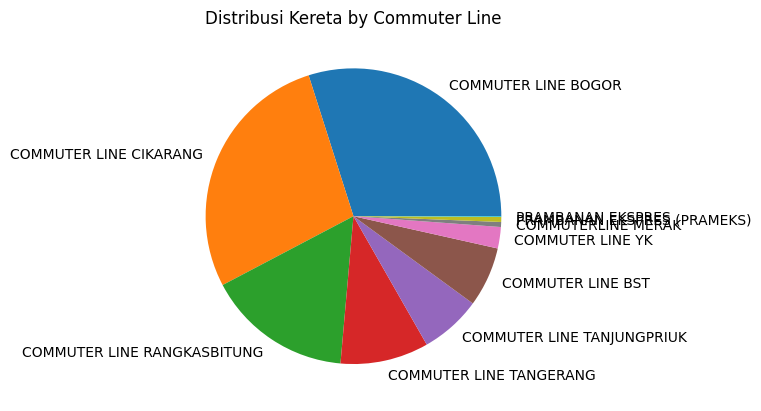

line
COMMUTER LINE BOGOR            29.91
COMMUTER LINE CIKARANG         27.80
COMMUTER LINE RANGKASBITUNG    15.89
COMMUTER LINE TANGERANG         9.66
COMMUTER LINE TANJUNGPRIUK      6.70
COMMUTER LINE BST               6.54
COMMUTER LINE YK                2.34
COMMUTERLINE MERAK              0.55
PRAMBANAN EKSPRES (PRAMEKS)     0.55
PRAMBANAN EKSPRES               0.08
Name: train_id, dtype: float64

In [45]:
# distribusi kereta yang tersedia by line
df.groupby("line")["train_id"].nunique().sort_values(ascending=False).plot(kind="pie")
plt.title("Distribusi Kereta by Commuter Line")
plt.ylabel("")
plt.show()

line_dist = round(df.groupby("line")["train_id"].nunique().sort_values(ascending=False) / df["train_id"].nunique() * 100, 2)
line_dist

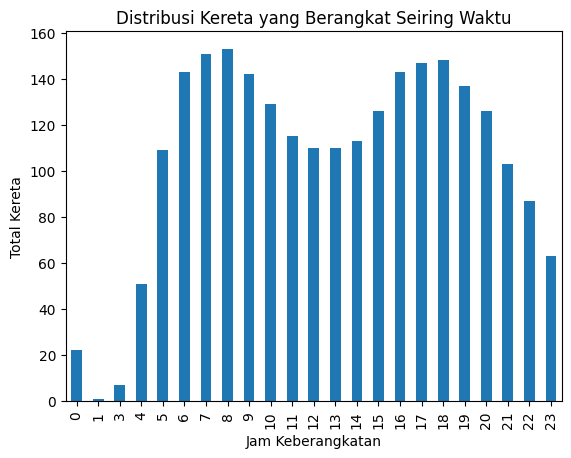

In [46]:
# kapan waktu puncak keterediaan kereta
df.groupby('time_estimated_hour')['train_id'].nunique().plot(kind="bar")
plt.title("Distribusi Kereta yang Berangkat Seiring Waktu")
plt.xlabel("Jam Keberangkatan")
plt.ylabel("Total Kereta")
plt.show()

In [47]:
# stasiun dengan ketersediaan kereta terbanyak
top_busiest_station = df.groupby("station_name")["train_id"].nunique().sort_values(ascending=False).head(5)
print("STASIUN TERSIBUK")
top_busiest_station

STASIUN TERSIBUK


station_name
MANGGARAI     532
TANAHABANG    363
DURI          357
CITAYAM       356
DEPOK         347
Name: train_id, dtype: int64

In [48]:
# stasiun dengan line terbanyak
print("Maximal line yang tersedia di satu stasiun:", df.groupby("station_name")["line"].nunique().max())
print("Stasiun dengan line tersedia terbanyak:")
line_passed = df.groupby("station_name")["line"].nunique()
line_passed[line_passed == 4]

Maximal line yang tersedia di satu stasiun: 4
Stasiun dengan line tersedia terbanyak:


station_name
KARET            4
MANGGARAI        4
SUDIRMAN         4
SUDIRMAN BARU    4
TANAHABANG       4
Name: line, dtype: int64

In [49]:
# tujuan akhir terbanyak berdasarkan rute
print("Tujuan akhir stasiun dari rute")
df.groupby("destination")["route"].nunique().sort_values(ascending=False).head(6)

Tujuan akhir stasiun dari rute


destination
JAKARTAKOTA      8
MANGGARAI        8
CIKARANG         6
BEKASI           4
TANAHABANG       4
KAMPUNGBANDAN    4
Name: route, dtype: int64

In [50]:
# mengambil contoh destinati akhir di cikarang
df[df["destination"] == "CIKARANG"]["route"].unique()

array(['KAMPUNGBANDAN-CIKARANG', 'ANGKE-CIKARANG', 'JAKARTAKOTA-CIKARANG',
       'BEKASI-CIKARANG', 'MANGGARAI-CIKARANG', 'CAKUNG-CIKARANG'],
      dtype=object)

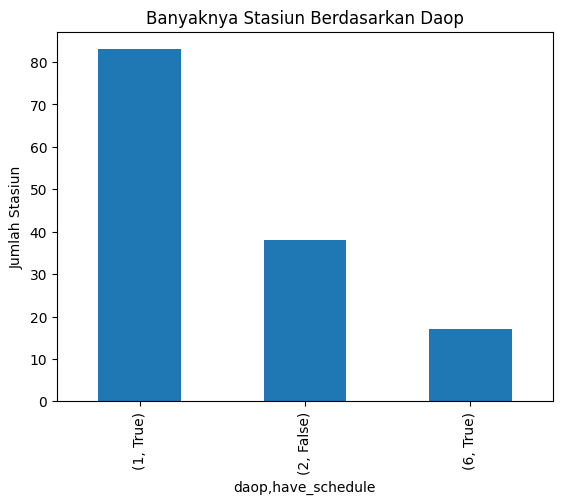

In [51]:
station.groupby(["daop", "have_schedule"])["name"].nunique().plot(kind="bar")
plt.ylabel("Jumlah Stasiun")
plt.title("Banyaknya Stasiun Berdasarkan Daop")
plt.show()

In [52]:
# melihat stasiun dari daop 2 -> wilayah BANDUNG
station[station["daop"] == 2]
# daop 2 adalah stasiun yang tidak memiliki KRL

,id,name,daop,fg_enable,have_schedule,updated_at
3,BD,BANDUNG,2,1,False,2024-03-10T15:15:19.997Z
12,CA,CIGANEA,2,1,False,2024-03-10T15:15:19.997Z
13,CB,CIBATU,2,1,False,2024-03-10T15:15:19.997Z
15,CBR,CIBUNGUR,2,1,False,2024-03-10T15:15:19.997Z
17,CCL,CICALENGKA,2,1,False,2024-03-10T15:15:19.997Z
18,CD,CIKADONGDONG,2,1,False,2024-03-10T15:15:19.997Z
23,CKP,CIKAMPEK,2,1,False,2024-03-10T15:15:19.997Z
26,CLE,CILAME,2,1,False,2024-03-10T15:15:19.997Z
28,CMD,CIMINDI,2,1,False,2024-03-10T15:15:19.997Z
29,CMI,CIMAHI,2,1,False,2024-03-10T15:15:19.997Z


In [53]:
# melihat stasiun dari daop 6 -> wilayah COMMUTER LINE YOGYAKARTA
station[station["daop"] == 6]

,id,name,daop,fg_enable,have_schedule,updated_at
2,BBN,BRAMBANAN,6,1,True,2024-03-10T15:15:19.997Z
19,CE,CEPER,6,1,True,2024-03-10T15:15:19.997Z
38,DL,DELANGGU,6,1,True,2024-03-10T15:15:19.997Z
50,GW,GAWOK,6,1,True,2024-03-10T15:15:19.997Z
55,JN,JENAR,6,1,True,2024-03-10T15:15:19.997Z
72,KT,KLATEN,6,1,True,2024-03-10T15:15:19.997Z
73,KTA,KUTOARJO,6,1,True,2024-03-10T15:15:19.997Z
80,LPN,LEMPUYANGAN,6,1,True,2024-03-10T15:15:19.997Z
82,MGW,MAGUWO,6,1,True,2024-03-10T15:15:19.997Z
92,PL,PALUR,6,1,True,2024-03-10T15:15:19.997Z


In [54]:
# banyaknya train_id yang melewati stasiun
train_station = df.groupby("train_id")["station_name"].nunique().sort_values(ascending=False)
print("Rata-rata kereta melewati berapa stasiun? :", round(train_station.mean()))
print("Berapa stasiun yang dilewati setiap kereta?")
train_station

Rata-rata kereta melewati berapa stasiun? : 14
Berapa stasiun yang dilewati setiap kereta?


train_id
1358B      23
1272B      23
1303B      23
1302B      23
1301B      23
           ..
304         1
306         1
312         1
310         1
D1/314A     1
Name: station_name, Length: 1284, dtype: int64

## Konklusi

KRL Commuter Line adalah sistem transportasi angkutan cepat komuter berbasis kereta rel listrik (KRL) yang dioperasikan oleh PT Kereta Commuter Indonesia (KAI Commuter) (Wikipedia). Pada data yang telah dieksplorasi, daerah operasional 2 (wilayah Bandung) tidak memiliki KRL yang beroperasi. Sementara itu, daerah operasional 1 (wilayah JABODETABEK) dan daerah operasional 6 (wilayah Yogyakarta) memiliki KRL yang beroperasi. Fokus kita adalah menganlisis daerah yang memiliki KRL. Adapun rekomendasi dari hasil analisis adalah sebagai berikut:

1. Peak hours pukul 7-8 pagi dan 5-6 sore
- menyediakan ketersiadaan kereta tambahan pada jam-jam tersebut.
- untuk mengurangi penumpang, pihak terkait dapat menerapakan diskon di luar jam-jam puncak tersebut atau menawarkan promosi khusus untuk mendorong penumpang menyesuaikan waktu perjalanan mereka.
- mengatur penjadwalan maintenance di luar jam-jam puncak.

2. Stasiun tersibuk seperti manggarai, tanahabang, duri, dll.
- menyediakan frekuensi kereta yang lebih banyak.
- berkolabriasi dengan pihak eksternal untuk mengatasi atau mengurai kemacetan di daerah sekitar.
- mengedukasi dan pemberian informasi yang lebih mudah diakses tentang jadwal kereta, rute, dan layanan kereta.
- meningkatkan kualitas keamanan, seperti adanya CCTV, adanya pos pengaduan, dll.
- mengadakan analisis kepuasan penumpang untuk mengevaluasi kegiatan operasional kereta.

3. Distrubsi ketersediaan kereta by line
- prioritas sumber daya yaitu jalur-jalur seperti Commuter Line Bogor, Cikarang, dan Rangkasbitung memegang persentase yang besar, mungkin penting untuk memprioritaskan alokasi sumber daya seperti kereta tambahan, staf stasiun tambahan, dan perawatan infrastruktur pada jalur-jalur ini untuk memastikan ketersediaan yang optimal dan kepuasan penumpang.
- mengadakan analisis Kepuasan Penumpang: Dengan memantau data penumpang secara teratur, kita dapat melihat apakah distribusi jalur berdampak pada kepuasan penumpang. Jika ada ketidaksesuaian antara preferensi penumpang dan layanan yang disediakan, mungkin perlu dilakukan penyesuaian lebih lanjut.